# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb
from util.helper import * 
import util.helper as helpfun
import matplotlib.pyplot as plt
import seaborn as sns

## <span style="color:#ff5f27;"> Prepare training features</span>

In [2]:
# Get current working directory
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

Current directory: C:\Users\marth\OneDrive - KTH\[Y1] Period 2\ID2223 Scalable Machine Learning and Deep Learning\Projects\Final Pj\ID2223-Final-Project


In [3]:
# Construct path
data_path = os.path.join(current_dir, 'model', 'training_feature.csv')
training_df = pd.read_csv(data_path)
#print(training_df)

C:\Users\marth\AppData\Local\Temp\ipykernel_7460\2534620820.py:3: DtypeWarning: Columns (134,136,137,138,140,144,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,167,171,173,174,175,177) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(data_path)


In [4]:
check_dataframe_types(training_df)

=== DataFrame Overview ===
Shape: (17388, 348)

=== Data Types Summary ===
float64    255
object      71
int64       22
Name: count, dtype: int64

=== Mixed Type Columns ===

Column: champion
Types found: ['str', 'float']
Sample values: ['Graves', "K'Sante", 'Braum']

Column: date
Types found: ['str', 'float']
Sample values: ['Tue, Dec 10, 2024 7:34 PM', 'Sat, Dec 28, 2024 8:46 PM', 'Sat, Jan 4, 2025 7:04 PM']

Column: most_champ_2
Types found: ['str', 'float']
Sample values: ['Seraphine', 'Ezreal', 'Varus']

Column: most_champ_3
Types found: ['str', 'float']
Sample values: ['Renekton', 'Braum', 'Nautilus']

Column: season_champ_1
Types found: ['str', 'float']
Sample values: ['Riven', 'Syndra', "K'Sante"]

Column: season_champ_2
Types found: ['str', 'float']
Sample values: ['Rell', 'Nami', 'Lulu']

Column: season_champ_3
Types found: ['str', 'float']
Sample values: ['Janna', 'Ezreal', 'Alistar']

Column: season_champ_4
Types found: ['str', 'float']
Sample values: ['Corki', 'Taliyah', '

,dtype,non_null,null_count,unique_values,sample_values
champion,object,17300,88,168,"[Aurora, Lillia, Skarner]"
player_id,object,17388,0,870,"[Ông Bầu Suneo #cxo, Gok Gymer #thien, Nomi #EUW]"
region,object,17388,0,4,"[na, euw, euw]"
date,object,17386,2,9277,"[Fri, Jan 3, 2025 10:57 AM, Sun, Dec 22, 2024 ..."
level,float64,17300,88,16,"[12.0, 9.0, 8.0]"
...,...,...,...,...,...
Zeri,float64,17388,0,103,"[0.071530406504065, 0.0841147169811321, 0.0715..."
Ziggs,float64,17388,0,86,"[0.0903857142857143, 0.1410138461538461, 0.081..."
Zilean,float64,17388,0,26,"[0.0573491304347826, 0.0465395238095238, 0.046..."
Zoe,float64,17388,0,105,"[0.068298901098901, 0.0440090109890109, 0.0682..."


In [7]:
#Check float Value vs NaN
column_check = ['champion','date', 'most_champ_2','most_champ_3', 'season_champ_1', 'season_champ_2', 'season_champ_3', 'season_champ_4', 
              'season_champ_5', 'season_champ_6', 'season_champ_7']

column_check2 = ['7d_champ_1', '7d_W_1', '7d_WR_1']

for col in column_check2:
    check_nan_float(training_df, col)

Are all float values NaN? True
Number of float values: 1258
Number of NaN values: 1258
Are all float values NaN? False
Number of float values: 11079
Number of NaN values: 1857
Are all float values NaN? False
Number of float values: 11719
Number of NaN values: 2497


In [7]:
# Remove rows where champion is NaN
training_df = training_df.dropna(subset=['champion'])

# Verify no more NaN in champion column
print(f"\nRemaining NaN in champion column: {training_df['champion'].isna().sum()}")


Remaining NaN in champion column: 0


In [8]:
#Clean table and convert string to num, remove future stats
training_df = convert_training_df(training_df)
print(training_df)

       champion  region          date  team  avg_tier  team_champ1  \
0           130       1  1.736014e+09     2         1           40   
1            19       1  1.736012e+09     1         2          111   
2            37       1  1.736010e+09     1         2           42   
3           125       1  1.736009e+09     1         2            6   
4            96       1  1.735932e+09     2         2           80   
...         ...     ...           ...   ...       ...          ...   
17383         3       3  1.734515e+09     2         2           42   
17384        43       3  1.734513e+09     2         2          150   
17385        28       3  1.734511e+09     2         2          150   
17386       160       3  1.734269e+09     2         2          118   
17387        53       3  1.734262e+09     1         2           81   

       team_champ2  team_champ3  team_champ4  opp_champ1  ...      Yone  \
0               71           33          106         129  ...  0.671335   
1        

In [8]:
def calculate_champ_variety_score(df):
    df = df.copy()  # Create a copy to avoid warnings
    
    # Create a list of champion columns we want to check
    champ_columns = [
        'most_champ_1', 'most_champ_2', 'most_champ_3',
        '7d_champ_1', '7d_champ_2', '7d_champ_3'
    ]
    
    # Filter to only include columns that exist in the DataFrame
    existing_columns = [col for col in champ_columns if col in df.columns]
    
    # Function to count unique non-NaN values
    def count_unique_champions(row):
        # Get all values that are not NaN
        valid_champions = row[existing_columns].dropna()
        # Count unique values
        return len(set(valid_champions))
    
    # Calculate the score for each row
    df['champ_variety_score'] = df.apply(count_unique_champions, axis=1)
    
    return df

In [9]:
def calculate_playstyle(df):
    df = df.copy()
    
    # Playstyle categorization (0-5)
    conditions = [
        # 0: Assassin/Carry (high kills, high KDA, high kill participation)
        (df['avg_kills'] > df['avg_assists']) & 
        (df['kda_ratio_profile'] > 3) & 
        (df['kill_participation_profile'] > 0.6),
        
        # 1: Support/Utility (high assists, good KDA, high kill participation)
        (df['avg_assists'] > df['avg_kills']) & 
        (df['kda_ratio_profile'] > 2.5) & 
        (df['kill_participation_profile'] > 0.55),
        
        # 2: Tank/Initiator (moderate deaths, high assists, high kill participation)
        (df['avg_deaths'] > 3) & 
        (df['avg_assists'] > df['avg_kills']) & 
        (df['kill_participation_profile'] > 0.5),
        
        # 3: Split-pusher (lower kill participation, good KDA)
        (df['kill_participation_profile'] < 0.5) & 
        (df['kda_ratio_profile'] > 2),
        
        # 4: Aggressive/Fighter (high kills and deaths, high kill participation)
        (df['avg_kills'] > 3) & 
        (df['avg_deaths'] > 4) & 
        (df['kill_participation_profile'] > 0.55)
    ]
    
    values = [0, 1, 2, 3, 4]  # Numeric values for each playstyle
    df['playstyle'] = np.select(conditions, values, default=5)
    
    return df

In [9]:
check_dataframe_types(training_df)

=== DataFrame Overview ===
Shape: (17300, 326)

=== Data Types Summary ===
float64    278
int64       32
object      16
Name: count, dtype: int64

=== Mixed Type Columns ===

Column: 7d_W_1
Types found: ['float', 'str']
Sample values: [3.0, 'Rell', 'Gnar']

Column: 7d_WR_1
Types found: ['float', 'str']
Sample values: [0.43, 1.0, 'Viego']

Column: 7d_total_2
Types found: ['float', 'str']
Sample values: [1.0, 1.0, 'Zed']

Column: 7d_L_2
Types found: ['float', 'str']
Sample values: ['Lee Sin', 1.0, "Kha'Zix"]

Column: 7d_W_3
Types found: ['float', 'str']
Sample values: [1.0, 0.0, 4.0]

Column: 7d_WR_3
Types found: ['float', 'str']
Sample values: ['Sylas', 0.0, 0.0]

Column: m_lv_1
Types found: ['int', 'str', 'float']
Sample values: [15, 15, 12]

Column: m_lv_2
Types found: ['float', 'str']
Sample values: [73.0, 17.0, 77.0]

Column: m_lv_3
Types found: ['float', 'str']
Sample values: [44.0, 14.0, 0.0]

Column: m_lv_4
Types found: ['float', 'str']
Sample values: ['Pyke', 33.0, 'Gragas']

Co

,dtype,non_null,null_count,unique_values,sample_values
champion,int64,17300,0,168,"[100, 27, 44]"
region,int64,17300,0,4,"[3, 1, 3]"
date,float64,17298,2,9228,"[1735779180.0, 1735945740.0, 1735891140.0]"
team,int64,17300,0,2,"[1, 2, 1]"
avg_tier,int64,17300,0,3,"[3, 2, 2]"
...,...,...,...,...,...
Zeri,float64,17300,0,103,"[0.0841147169811321, 0.0643773658536585, 0.084..."
Ziggs,float64,17300,0,86,"[0.0903857142857143, 0.158462928, 0.0813471428..."
Zilean,float64,17300,0,26,"[0.0573491304347826, 0.0, 0.0516142173913043]"
Zoe,float64,17300,0,105,"[0.0488989010989011, 0.068298901098901, 0.0682..."


In [11]:
training_df = calculate_champ_variety_score(training_df)
print(training_df)

       champion  region          date  team  avg_tier  team_champ1  \
0           130       1  1.736014e+09     2         1           40   
1            19       1  1.736012e+09     1         2          111   
2            37       1  1.736010e+09     1         2           42   
3           125       1  1.736009e+09     1         2            6   
4            96       1  1.735932e+09     2         2           80   
...         ...     ...           ...   ...       ...          ...   
17383         3       3  1.734515e+09     2         2           42   
17384        43       3  1.734513e+09     2         2          150   
17385        28       3  1.734511e+09     2         2          150   
17386       160       3  1.734269e+09     2         2          118   
17387        53       3  1.734262e+09     1         2           81   

       team_champ2  team_champ3  team_champ4  opp_champ1  ...    Yorick  \
0               71           33          106         129  ...  0.033146   
1        

In [12]:
training_df = calculate_playstyle(training_df)
print(training_df)

       champion  region          date  team  avg_tier  team_champ1  \
0           130       1  1.736014e+09     2         1           40   
1            19       1  1.736012e+09     1         2          111   
2            37       1  1.736010e+09     1         2           42   
3           125       1  1.736009e+09     1         2            6   
4            96       1  1.735932e+09     2         2           80   
...         ...     ...           ...   ...       ...          ...   
17383         3       3  1.734515e+09     2         2           42   
17384        43       3  1.734513e+09     2         2          150   
17385        28       3  1.734511e+09     2         2          150   
17386       160       3  1.734269e+09     2         2          118   
17387        53       3  1.734262e+09     1         2           81   

       team_champ2  team_champ3  team_champ4  opp_champ1  ...  Yuumi  \
0               71           33          106         129  ...    0.0   
1              

In [13]:
# Add top 20 highest score features
top_champ_scores = training_df.apply(get_top_champion_scores, n=5, axis=1) #champion variety 5
training_df = pd.concat([training_df, top_champ_scores], axis=1)
print(training_df)

       champion  region          date  team  avg_tier  team_champ1  \
0           130       1  1.736014e+09     2         1           40   
1            19       1  1.736012e+09     1         2          111   
2            37       1  1.736010e+09     1         2           42   
3           125       1  1.736009e+09     1         2            6   
4            96       1  1.735932e+09     2         2           80   
...         ...     ...           ...   ...       ...          ...   
17383         3       3  1.734515e+09     2         2           42   
17384        43       3  1.734513e+09     2         2          150   
17385        28       3  1.734511e+09     2         2          150   
17386       160       3  1.734269e+09     2         2          118   
17387        53       3  1.734262e+09     1         2           81   

       team_champ2  team_champ3  team_champ4  opp_champ1  ...  1_champ_score  \
0               71           33          106         129  ...        0.84349   

In [14]:
# List of columns to remove
date = ['date']
recent_stats = ['total_games', 'wins', 'losses', 'win_rate', 'avg_kills', 'avg_deaths', 'avg_assists', 'kda_ratio_profile', 'kill_participation_profile']
recent_champs = ['most_champ_1', 'most_champ_2']
recent_champs_2 = ['most_champ_3']
recent_champs_stats = ['WR_1', 'W_1', 'L_1', 'KDA_1','WR_2', 'W_2', 'L_2', 'KDA_2', 'WR_3', 'W_3', 'L_3', 'KDA_3']
preferred_roles = ['TOP', 'JUNGLE', 'MID', 'ADC', 'SUPPORT']  
most_roles = ['most_role_1', 'most_role_2']
most_roles_value= ['most_role_1_value', 'most_role_2_value']
season_champ_top3 = ['season_champ_1', 'season_champ_2''season_champ_3']
season_stats = [ 'cs_ssn_1', 'cpm_ssn_1', 'kda_ssn_1', 
    'k_ssn_1', 'd_ssn_1', 'a_ssn_1', 'wr_ssn_1', 'games_ssn_1',  'cs_ssn_2', 
    'cpm_ssn_2', 'kda_ssn_2', 'k_ssn_2', 'd_ssn_2', 'a_ssn_2', 'wr_ssn_2', 'games_ssn_2', 
     'cs_ssn_3', 'cpm_ssn_3', 'kda_ssn_3', 'k_ssn_3', 'd_ssn_3', 'a_ssn_3', 
    'wr_ssn_3', 'games_ssn_3', 'season_champ_4', 'cs_ssn_4', 'cpm_ssn_4', 'kda_ssn_4', 'k_ssn_4', 
    'd_ssn_4', 'a_ssn_4', 'wr_ssn_4', 'games_ssn_4', 'season_champ_5', 'cs_ssn_5', 'cpm_ssn_5', 
    'kda_ssn_5', 'k_ssn_5', 'd_ssn_5', 'a_ssn_5', 'wr_ssn_5', 'games_ssn_5', 'season_champ_6', 
    'cs_ssn_6', 'cpm_ssn_6', 'kda_ssn_6', 'k_ssn_6', 'd_ssn_6', 'a_ssn_6', 'wr_ssn_6', 'games_ssn_6', 
    'season_champ_7', 'cs_ssn_7', 'cpm_ssn_7', 'kda_ssn_7', 'k_ssn_7', 'd_ssn_7', 'a_ssn_7', 
    'wr_ssn_7', 'games_ssn_7']
weekly_stats_1=['7d_champ_1', '7d_total_1',  '7d_WR_1', '7d_champ_2', '7d_total_2',  '7d_WR_2', '7d_champ_3', '7d_total_3', '7d_WR_3']
weekly_stats_2=['7d_W_1', '7d_L_1', '7d_W_2', '7d_L_2','7d_W_3', '7d_L_3']
mastery_stats=['mastery_champ_1', 'm_lv_1', 'mastery_champ_2', 'm_lv_2', 
    'mastery_champ_3', 'm_lv_3', 'mastery_champ_4', 'm_lv_4', 'mastery_champ_5', 'm_lv_5', 
    'mastery_champ_6', 'm_lv_6', 'mastery_champ_7', 'm_lv_7', 'mastery_champ_8', 'm_lv_8', 
    'mastery_champ_9', 'm_lv_9', 'mastery_champ_10', 'm_lv_10', 'mastery_champ_11', 'm_lv_11', 
    'mastery_champ_12', 'm_lv_12', 'mastery_champ_13', 'm_lv_13', 'mastery_champ_14', 'm_lv_14', 
    'mastery_champ_15', 'm_lv_15', 'mastery_champ_16', 'm_lv_16']
champions = [
            "Aatrox", "Ahri", "Akali", "Akshan", "Alistar", "Ambessa", "Amumu", "Anivia", "Annie", "Aphelios", "Ashe", "Aurelion Sol",
            "Aurora", "Azir", "Bard", "Bel'Veth", "Blitzcrank", "Brand", "Braum", "Briar", "Caitlyn", "Camille", "Cassiopeia", "Cho'Gath",
            "Corki", "Darius", "Diana", "Dr. Mundo", "Draven", "Ekko", "Elise", "Evelynn", "Ezreal", "Fiddlesticks", "Fiora", "Fizz", "Galio",
            "Gangplank", "Garen", "Gnar", "Gragas", "Graves", "Gwen", "Hecarim", "Heimerdinger", "Hwei", "Illaoi", "Irelia", "Ivern", "Janna",
            "Jarvan IV", "Jax", "Jayce", "Jhin", "Jinx", "K'Sante", "Kai'Sa", "Kalista", "Karma", "Karthus", "Kassadin", "Katarina", "Kayle",
            "Kayn", "Kennen", "Kha'Zix", "Kindred", "Kled", "Kog'Maw", "LeBlanc", "Lee Sin", "Leona", "Lillia", "Lissandra", "Lucian", "Lulu",
            "Lux", "Malphite", "Malzahar", "Maokai", "Master Yi", "Milio", "Miss Fortune", "Mordekaiser", "Morgana", "Naafiri", "Nami", "Nasus",
            "Nautilus", "Neeko", "Nidalee", "Nilah", "Nocturne", "Nunu & Willump", "Olaf", "Orianna", "Ornn", "Pantheon", "Poppy", "Pyke",
            "Qiyana", "Quinn", "Rakan", "Rammus", "Rek'Sai", "Rell", "Renata Glasc", "Renekton", "Rengar", "Riven", "Rumble", "Ryze", "Samira",
            "Sejuani", "Senna", "Seraphine", "Sett", "Shaco", "Shen", "Shyvana", "Singed", "Sion", "Sivir", "Skarner", "Smolder", "Sona",
            "Soraka", "Swain", "Sylas", "Syndra", "Tahm Kench", "Taliyah", "Talon", "Taric", "Teemo", "Thresh", "Tristana", "Trundle",
            "Tryndamere", "Twisted Fate", "Twitch", "Udyr", "Urgot", "Varus", "Vayne", "Veigar", "Vel'Koz", "Vex", "Vi", "Viego", "Viktor",
            "Vladimir", "Volibear", "Warwick", "Wukong", "Xayah", "Xerath", "Xin Zhao", "Yasuo", "Yone", "Yorick", "Yuumi", "Zac", "Zed",
            "Zeri", "Ziggs", "Zilean", "Zoe", "Zyra"
        ]
champion_score = ['1_champ_score', '2_champ_score', '3_champ_score', '4_champ_score', '5_champ_score']
tier = ['avg_tier']
# Combine all columns to remove into a single list
columns_to_remove = []

# Include categories conditionally
columns_to_remove += date
columns_to_remove += recent_stats
#columns_to_remove += recent_champs
columns_to_remove += recent_champs_2
columns_to_remove += recent_champs_stats
columns_to_remove += preferred_roles
columns_to_remove += most_roles
#columns_to_remove += most_roles_value
#columns_to_remove += season_champ_top3
columns_to_remove += season_stats
columns_to_remove += weekly_stats_1
columns_to_remove += weekly_stats_2
columns_to_remove += mastery_stats
columns_to_remove += champions
columns_to_remove += champion_score
columns_to_remove += tier

# Drop the specified columns
training_df = training_df.drop(columns=columns_to_remove)

# Display the resulting DataFrame
print(training_df)

       champion  region  team  avg_tier  team_champ1  team_champ2  \
0           130       1     2         1           40           71   
1            19       1     1         2          111           71   
2            37       1     1         2           42           48   
3           125       1     1         2            6           91   
4            96       1     2         2           80           93   
...         ...     ...   ...       ...          ...          ...   
17383         3       3     2         2           42          160   
17384        43       3     2         2          150           48   
17385        28       3     2         2          150          168   
17386       160       3     2         2          118          130   
17387        53       3     1         2           81          159   

       team_champ3  team_champ4  opp_champ1  opp_champ2  ...  season_champ_1  \
0               33          106         129         150  ...           129.0   
1          

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

In [15]:
#training df reset for debug purpose
current_dir = os.getcwd()

# Construct path
data_path = os.path.join(current_dir, 'model', 'training_feature.csv')
training_df = pd.read_csv(data_path)

training_df = training_df.dropna(subset=['champion'])

#Clean table and convert string to num, remove future stats
training_df = convert_training_df(training_df)

training_df = calculate_champ_variety_score(training_df)

training_df = calculate_playstyle(training_df)

# Add top 3 highest score features
top_champ_scores = training_df.apply(get_top_champion_scores, n=5, axis=1) #champion variety 5
training_df = pd.concat([training_df, top_champ_scores], axis=1)

# List of columns to remove
date = ['date']
recent_stats = ['total_games', 'wins', 'losses', 'win_rate', 'avg_kills', 'avg_deaths', 'avg_assists', 'kda_ratio_profile', 'kill_participation_profile']
recent_champs = ['most_champ_1', 'most_champ_2']
recent_champs_2 = ['most_champ_3']
recent_champs_stats = ['WR_1', 'W_1', 'L_1', 'KDA_1','WR_2', 'W_2', 'L_2', 'KDA_2', 'WR_3', 'W_3', 'L_3', 'KDA_3']
preferred_roles = ['TOP', 'JUNGLE', 'MID', 'ADC', 'SUPPORT']  
most_roles = ['most_role_1', 'most_role_2']
most_roles_value= ['most_role_1_value', 'most_role_2_value']
season_champ_top3 = ['season_champ_1', 'season_champ_2''season_champ_3']
season_stats = [ 'cs_ssn_1', 'cpm_ssn_1', 'kda_ssn_1', 
    'k_ssn_1', 'd_ssn_1', 'a_ssn_1', 'wr_ssn_1', 'games_ssn_1',  'cs_ssn_2', 
    'cpm_ssn_2', 'kda_ssn_2', 'k_ssn_2', 'd_ssn_2', 'a_ssn_2', 'wr_ssn_2', 'games_ssn_2', 
     'cs_ssn_3', 'cpm_ssn_3', 'kda_ssn_3', 'k_ssn_3', 'd_ssn_3', 'a_ssn_3', 
    'wr_ssn_3', 'games_ssn_3', 'season_champ_4', 'cs_ssn_4', 'cpm_ssn_4', 'kda_ssn_4', 'k_ssn_4', 
    'd_ssn_4', 'a_ssn_4', 'wr_ssn_4', 'games_ssn_4', 'season_champ_5', 'cs_ssn_5', 'cpm_ssn_5', 
    'kda_ssn_5', 'k_ssn_5', 'd_ssn_5', 'a_ssn_5', 'wr_ssn_5', 'games_ssn_5', 'season_champ_6', 
    'cs_ssn_6', 'cpm_ssn_6', 'kda_ssn_6', 'k_ssn_6', 'd_ssn_6', 'a_ssn_6', 'wr_ssn_6', 'games_ssn_6', 
    'season_champ_7', 'cs_ssn_7', 'cpm_ssn_7', 'kda_ssn_7', 'k_ssn_7', 'd_ssn_7', 'a_ssn_7', 
    'wr_ssn_7', 'games_ssn_7']
weekly_stats_1=['7d_champ_1', '7d_total_1',  '7d_WR_1', '7d_champ_2', '7d_total_2',  '7d_WR_2', '7d_champ_3', '7d_total_3', '7d_WR_3']
weekly_stats_2=['7d_W_1', '7d_L_1', '7d_W_2', '7d_L_2','7d_W_3', '7d_L_3']
mastery_stats=['mastery_champ_1', 'm_lv_1', 'mastery_champ_2', 'm_lv_2', 
    'mastery_champ_3', 'm_lv_3', 'mastery_champ_4', 'm_lv_4', 'mastery_champ_5', 'm_lv_5', 
    'mastery_champ_6', 'm_lv_6', 'mastery_champ_7', 'm_lv_7', 'mastery_champ_8', 'm_lv_8', 
    'mastery_champ_9', 'm_lv_9', 'mastery_champ_10', 'm_lv_10', 'mastery_champ_11', 'm_lv_11', 
    'mastery_champ_12', 'm_lv_12', 'mastery_champ_13', 'm_lv_13', 'mastery_champ_14', 'm_lv_14', 
    'mastery_champ_15', 'm_lv_15', 'mastery_champ_16', 'm_lv_16']
champions = [
            "Aatrox", "Ahri", "Akali", "Akshan", "Alistar", "Ambessa", "Amumu", "Anivia", "Annie", "Aphelios", "Ashe", "Aurelion Sol",
            "Aurora", "Azir", "Bard", "Bel'Veth", "Blitzcrank", "Brand", "Braum", "Briar", "Caitlyn", "Camille", "Cassiopeia", "Cho'Gath",
            "Corki", "Darius", "Diana", "Dr. Mundo", "Draven", "Ekko", "Elise", "Evelynn", "Ezreal", "Fiddlesticks", "Fiora", "Fizz", "Galio",
            "Gangplank", "Garen", "Gnar", "Gragas", "Graves", "Gwen", "Hecarim", "Heimerdinger", "Hwei", "Illaoi", "Irelia", "Ivern", "Janna",
            "Jarvan IV", "Jax", "Jayce", "Jhin", "Jinx", "K'Sante", "Kai'Sa", "Kalista", "Karma", "Karthus", "Kassadin", "Katarina", "Kayle",
            "Kayn", "Kennen", "Kha'Zix", "Kindred", "Kled", "Kog'Maw", "LeBlanc", "Lee Sin", "Leona", "Lillia", "Lissandra", "Lucian", "Lulu",
            "Lux", "Malphite", "Malzahar", "Maokai", "Master Yi", "Milio", "Miss Fortune", "Mordekaiser", "Morgana", "Naafiri", "Nami", "Nasus",
            "Nautilus", "Neeko", "Nidalee", "Nilah", "Nocturne", "Nunu & Willump", "Olaf", "Orianna", "Ornn", "Pantheon", "Poppy", "Pyke",
            "Qiyana", "Quinn", "Rakan", "Rammus", "Rek'Sai", "Rell", "Renata Glasc", "Renekton", "Rengar", "Riven", "Rumble", "Ryze", "Samira",
            "Sejuani", "Senna", "Seraphine", "Sett", "Shaco", "Shen", "Shyvana", "Singed", "Sion", "Sivir", "Skarner", "Smolder", "Sona",
            "Soraka", "Swain", "Sylas", "Syndra", "Tahm Kench", "Taliyah", "Talon", "Taric", "Teemo", "Thresh", "Tristana", "Trundle",
            "Tryndamere", "Twisted Fate", "Twitch", "Udyr", "Urgot", "Varus", "Vayne", "Veigar", "Vel'Koz", "Vex", "Vi", "Viego", "Viktor",
            "Vladimir", "Volibear", "Warwick", "Wukong", "Xayah", "Xerath", "Xin Zhao", "Yasuo", "Yone", "Yorick", "Yuumi", "Zac", "Zed",
            "Zeri", "Ziggs", "Zilean", "Zoe", "Zyra"
        ]
champion_score = ['1_champ_score', '2_champ_score', '3_champ_score', '4_champ_score', '5_champ_score']
tier = ['avg_tier']
# Combine all columns to remove into a single list
columns_to_remove = []

# Include categories conditionally
columns_to_remove += date
columns_to_remove += recent_stats
#columns_to_remove += recent_champs
columns_to_remove += recent_champs_2
columns_to_remove += recent_champs_stats
columns_to_remove += preferred_roles
columns_to_remove += most_roles
#columns_to_remove += most_roles_value
#columns_to_remove += season_champ_top3
columns_to_remove += season_stats
columns_to_remove += weekly_stats_1
columns_to_remove += weekly_stats_2
columns_to_remove += mastery_stats
columns_to_remove += champions
columns_to_remove += champion_score
columns_to_remove += tier

# Drop the specified columns
training_df = training_df.drop(columns=columns_to_remove)

# Display the resulting DataFrame
print(training_df)

C:\Users\marth\AppData\Local\Temp\ipykernel_18940\3238063176.py:6: DtypeWarning: Columns (134,136,137,138,140,144,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,167,171,173,174,175,177) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(data_path)


       champion  region  team  avg_tier  team_champ1  team_champ2  \
0           130       1     2         1           40           71   
1            19       1     1         2          111           71   
2            37       1     1         2           42           48   
3           125       1     1         2            6           91   
4            96       1     2         2           80           93   
...         ...     ...   ...       ...          ...          ...   
17383         3       3     2         2           42          160   
17384        43       3     2         2          150           48   
17385        28       3     2         2          150          168   
17386       160       3     2         2          118          130   
17387        53       3     1         2           81          159   

       team_champ3  team_champ4  opp_champ1  opp_champ2  ...  season_champ_1  \
0               33          106         129         150  ...           129.0   
1          

In [16]:
# Check data types
def check_datatypes(df):
    return pd.DataFrame({
        'dtype': df.dtypes,
        'unique_values': df.nunique()
    })

dtype_info = check_datatypes(training_df)
print("Feature data types:")
print(dtype_info)

print("\nChampion Variety Score Distribution (Percentages):")
percent_dist = (training_df['champ_variety_score'].value_counts(normalize=True) * 100).sort_index(ascending=False)
for score, percentage in percent_dist.items():
    print(f"Score {score}: {percentage:.2f}%")

Feature data types:
                       dtype  unique_values
champion               int64            168
region                 int64              4
team                   int64              2
avg_tier               int64              3
team_champ1            int64            149
team_champ2            int64            154
team_champ3            int64            143
team_champ4            int64            140
opp_champ1             int64            144
opp_champ2             int64             82
opp_champ3             int64            145
opp_champ4             int64            119
opp_champ5             int64            110
most_champ_1           int64            138
most_champ_2         float64            134
most_role_1_value    float64             15
most_role_2_value    float64             11
season_champ_1       float64            139
season_champ_2       float64            129
season_champ_3       float64            132
champ_variety_score    int64              6
playstyle   

In [17]:
def optimize_feature_dtypes(df):
    """
    Optimize data types for feature columns
    """
    df = df.copy()
    
    # Convert float64 champion columns to Int64 (nullable integer)
    champion_float_cols = [
        'most_champ_2',
        'season_champ_1', 'season_champ_2', 'season_champ_3',
        '1_champ_name', '2_champ_name', '3_champ_name', '4_champ_name', '5_champ_name'
    ]
    
    for col in champion_float_cols:
        df[col] = df[col].astype('Int64')  # Using Int64 to handle potential NaN values
    
    # Keep most_role values as float64 since they can be decimal
    role_value_cols = ['most_role_1_value', 'most_role_2_value']
    
    # Convert other integer columns to more memory-efficient types
    int_cols = {
        'champion': 'int32',
        'region': 'int8',    # Only 4 values
        'team': 'int8',      # Only 2 values
        'avg_tier': 'int8',  # Only 3 values
        'champ_variety_score': 'int8',  # Only 6 values
        'playstyle': 'int8'  # Only 6 values
    }
    
    for col, dtype in int_cols.items():
        df[col] = df[col].astype(dtype)
    
    # Print memory usage before and after optimization
    print("\nMemory usage per column after optimization:")
    print(df.memory_usage(deep=True))
    
    return df

In [18]:
# Apply the optimization
training_df = optimize_feature_dtypes(training_df)


Memory usage per column after optimization:
Index                  138400
champion                69200
region                  17300
team                    17300
avg_tier                17300
team_champ1            138400
team_champ2            138400
team_champ3            138400
team_champ4            138400
opp_champ1             138400
opp_champ2             138400
opp_champ3             138400
opp_champ4             138400
opp_champ5             138400
most_champ_1           138400
most_champ_2           155700
most_role_1_value      138400
most_role_2_value      138400
season_champ_1         155700
season_champ_2         155700
season_champ_3         155700
champ_variety_score     17300
playstyle               17300
1_champ_name           155700
2_champ_name           155700
3_champ_name           155700
4_champ_name           155700
5_champ_name           155700
dtype: int64


In [19]:
# Verify new data types
print("\nNew data types:")
for col in training_df.columns:
    print(f"{col:<20} {training_df[col].dtype}")

# Verify value ranges
print("\nValue ranges for key columns:")
for col in training_df.columns:
    if training_df[col].dtype in ['int8', 'int16', 'int32', 'Int64']:
        print(f"{col:<20} Min: {training_df[col].min()} Max: {training_df[col].max()}")


New data types:
champion             int32
region               int8
team                 int8
avg_tier             int8
team_champ1          int64
team_champ2          int64
team_champ3          int64
team_champ4          int64
opp_champ1           int64
opp_champ2           int64
opp_champ3           int64
opp_champ4           int64
opp_champ5           int64
most_champ_1         int64
most_champ_2         Int64
most_role_1_value    float64
most_role_2_value    float64
season_champ_1       Int64
season_champ_2       Int64
season_champ_3       Int64
champ_variety_score  int8
playstyle            int8
1_champ_name         Int64
2_champ_name         Int64
3_champ_name         Int64
4_champ_name         Int64
5_champ_name         Int64

Value ranges for key columns:
champion             Min: 1 Max: 169
region               Min: 1 Max: 4
team                 Min: 1 Max: 2
avg_tier             Min: 1 Max: 3
most_champ_2         Min: 2 Max: 169
season_champ_1       Min: 1 Max: 169
season_c

In [20]:
# Prepare train features
X = training_df.drop('champion', axis=1, errors='ignore')
y = training_df['champion']

In [21]:
##Remove rows with target group fewer than threshold 

threshold = 3

# Create a composite stratification label by combining 'region' and 'champion'
X['stratify_label'] = X['region'].astype(str) + '_' + y.astype(str)

# Count the instances of each stratification label
stratify_counts = X['stratify_label'].value_counts()

# Identify stratification labels with fewer than two instances
few_instance_stratify_labels = stratify_counts[stratify_counts < threshold].index

# Remove rows with stratification labels that have fewer than two instances
mask = ~X['stratify_label'].isin(few_instance_stratify_labels)
X_filtered = X[mask].copy()
y_filtered = y[mask].copy()

In [22]:
# Get the counts of each unique value in y_filtered
unique_counts = y.value_counts()

# Define the maximum threshold
max_threshold = 11

# Filter the counts to include only those less than the maximum threshold
filtered_counts = unique_counts[unique_counts < max_threshold]

# Calculate the total number of champions that meet the criteria
total_champions = len(filtered_counts)

# Display the result
print(f"Total number of champions with occurrences less than {max_threshold}: {total_champions}")

Total number of champions with occurrences less than 11: 20


In [23]:
# Encode the target values to start from 0
label_encoder = LabelEncoder()
y_filtered_encoded = label_encoder.fit_transform(y_filtered)

In [24]:
# First split: training and temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, 
    y_filtered_encoded,
    test_size=0.3,  # 70% for training
    random_state=42,
    stratify=X_filtered['stratify_label']  # Stratify by the composite label
)

In [25]:
# Drop the composite stratification label after usage
X_train = X_train.drop(columns=['stratify_label'])
X_temp = X_temp.drop(columns=['stratify_label'])

In [26]:
# Second split: validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,  # Split remaining 40% into two equal parts
    random_state=42,
    stratify=X_temp['region']  # Stratify by the composite label
)

In [27]:
# Print split information
print("\nSplit Summary:")
print(f"Training set:      {X_train.shape} ({len(X_train)/len(X):.1%})")
print(f"Validation set:    {X_val.shape} ({len(X_val)/len(X):.1%})")
print(f"Test set:         {X_test.shape} ({len(X_test)/len(X):.1%})")

# Check region distribution in each split
print("\nRegion Distribution in Splits:")
print("\nTraining Set:")
print(X_train['region'].value_counts(normalize=True))
print("\nValidation Set:")
print(X_val['region'].value_counts(normalize=True))
print("\nTest Set:")
print(X_test['region'].value_counts(normalize=True))

# Quick champion distribution check (optional)
print("\nChampion counts in each split:")
print(f"Training set unique champions: {np.unique(y_train).size}")
print(f"Validation set unique champions: {np.unique(y_val).size}")
print(f"Test set unique champions: {np.unique(y_test).size}")


Split Summary:
Training set:      (12015, 26) (69.5%)
Validation set:    (2575, 26) (14.9%)
Test set:         (2575, 26) (14.9%)

Region Distribution in Splits:

Training Set:
region
1    0.405243
2    0.343820
4    0.129338
3    0.121598
Name: proportion, dtype: float64

Validation Set:
region
1    0.405825
2    0.344078
4    0.128932
3    0.121165
Name: proportion, dtype: float64

Test Set:
region
1    0.405825
2    0.344078
4    0.128544
3    0.121553
Name: proportion, dtype: float64

Champion counts in each split:
Training set unique champions: 158
Validation set unique champions: 154
Test set unique champions: 153


In [28]:
for i, col in enumerate(X_train.columns):
    print(f"{i}: {col}")

0: region
1: team
2: avg_tier
3: team_champ1
4: team_champ2
5: team_champ3
6: team_champ4
7: opp_champ1
8: opp_champ2
9: opp_champ3
10: opp_champ4
11: opp_champ5
12: most_champ_1
13: most_champ_2
14: most_role_1_value
15: most_role_2_value
16: season_champ_1
17: season_champ_2
18: season_champ_3
19: champ_variety_score
20: playstyle
21: 1_champ_name
22: 2_champ_name
23: 3_champ_name
24: 4_champ_name
25: 5_champ_name


In [29]:
y_train

array([ 43, 103, 120, ...,  75, 147,  21], dtype=int64)

In [30]:
def analyze_champion_distribution(y_data, label_encoder):
    """
    Analyze champion distribution in the dataset
    """
    # Convert encoded labels back to champion names
    champion_names = label_encoder.inverse_transform(y_data)
    dist = pd.Series(champion_names).value_counts()
    
    print(f"\nChampion Distribution Analysis:")
    print(f"Total unique champions: {len(dist)}")
    print(f"Samples per champion:")
    print(f"  Min: {dist.min()}")
    print(f"  Max: {dist.max()}")
    print(f"  Mean: {dist.mean():.2f}")
    print(f"Champions with fewer than {threshold} samples: {len(dist[dist < threshold])}")
    
    return dist

def create_balanced_batches(X_data, y_data, batch_size=512):
    """
    Create balanced batches for training
    """
    champion_counts = Counter(y_data)
    champions = list(champion_counts.keys())
    
    # Create indices for each champion
    champion_indices = {
        champ: np.where(y_data == champ)[0]
        for champ in champions
    }
    
    # Shuffle indices
    for indices in champion_indices.values():
        np.random.shuffle(indices)
    
    # Calculate minimum samples per champion
    min_samples_per_champion = max(1, batch_size // len(champions))
    
    batches = []
    positions = {champ: 0 for champ in champions}
    
    while True:
        batch_indices = []
        
        # Add samples from each champion
        for champ in champions:
            indices = champion_indices[champ]
            pos = positions[champ]
            
            # Reset if needed
            if pos >= len(indices):
                np.random.shuffle(indices)
                positions[champ] = 0
                pos = 0
            
            # Add samples
            samples_to_add = min(min_samples_per_champion, len(indices) - pos)
            if samples_to_add > 0:
                batch_indices.extend(indices[pos:pos + samples_to_add])
                positions[champ] = pos + samples_to_add
        
        if len(batch_indices) > 0:
            batches.append(batch_indices)
        
        # Check if we've covered the dataset
        if all(positions[champ] >= len(champion_indices[champ]) for champ in champions):
            break
    
    return batches

In [31]:
initial_dist = analyze_champion_distribution(y_train, label_encoder)


Champion Distribution Analysis:
Total unique champions: 158
Samples per champion:
  Min: 2
  Max: 354
  Mean: 76.04
Champions with fewer than 3 samples: 2


---

## <span style="color:#ff5f27;">🧬 Modeling</span>

Pick XGBClassifier in champion prediction since it is a categorical variable

In [32]:
# Create the classifier without eval_metric_ops
xgb_classifier = XGBClassifier(
    max_depth=4,
    learning_rate=0.001,
    n_estimators=1000,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=5,
    reg_alpha=0.5,
    reg_lambda=1.5,
    gamma=0.2,
    objective='multi:softmax',
    tree_method='hist',
    enable_categorical=True,
    eval_metric=['merror', 'mlogloss'],
    random_state=42
)



In [33]:
# Create balanced dataset using the batch creation function
def create_balanced_dataset(X, y):
    """
    Create a balanced dataset for training
    """
    champion_counts = Counter(y)
    all_champions = list(champion_counts.keys())
    
    # Create indices for each champion
    champion_indices = {
        champ: np.where(y == champ)[0]
        for champ in all_champions
    }
    
    # Calculate the desired number of samples per champion
    max_samples_per_champion = max(champion_counts.values())
    
    balanced_indices = []
    for champ, indices in champion_indices.items():
        # Resample if needed
        if len(indices) < max_samples_per_champion:
            resampled_indices = np.random.choice(
                indices, 
                size=max_samples_per_champion, 
                replace=True
            )
            balanced_indices.extend(resampled_indices)
        else:
            balanced_indices.extend(indices[:max_samples_per_champion])
    
    return X.iloc[balanced_indices], y[balanced_indices]

In [34]:
X_train_balanced, y_train_balanced = create_balanced_dataset(X_train, y_train)

In [40]:
xgb_classifier.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100,
    callbacks=[xgb.callback.EarlyStopping(
        rounds=20,
        metric='validation_1-merror',  # Use validation error for early stopping
        save_best=True
    )]
)

TypeError: EarlyStopping.__init__() got an unexpected keyword argument 'metric'

In [37]:
# Get the best iteration from early stopping
# Get the best iteration
print(f"\nBest iteration: {xgb_classifier.best_iteration}")
print(f"Best validation score: {xgb_classifier.best_score}")


Best iteration: 999
Best validation score: 3.5171504338273722



Top 20 Most Important Features:
                feature  importance
12         most_champ_1    0.094780
16       season_champ_1    0.071921
21         1_champ_name    0.061310
15    most_role_2_value    0.058588
19  champ_variety_score    0.057836
0                region    0.057809
18       season_champ_3    0.056343
20            playstyle    0.051510
17       season_champ_2    0.047166
13         most_champ_2    0.046819
14    most_role_1_value    0.045912
22         2_champ_name    0.036904
23         3_champ_name    0.032255
11           opp_champ5    0.026701
24         4_champ_name    0.026411
6           team_champ4    0.026050
25         5_champ_name    0.023974
7            opp_champ1    0.023960
9            opp_champ3    0.021441
4           team_champ2    0.020985

Top 20 Least Important Features:
              feature  importance
18     season_champ_3    0.056343
20          playstyle    0.051510
17     season_champ_2    0.047166
13       most_champ_2    0.046819
14  mos

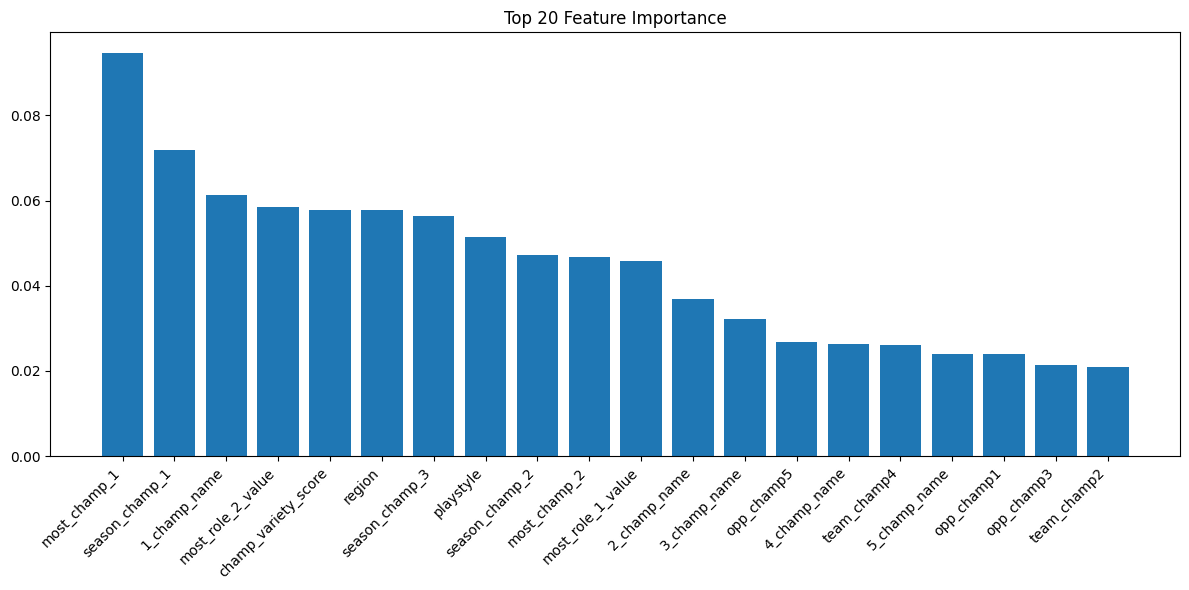

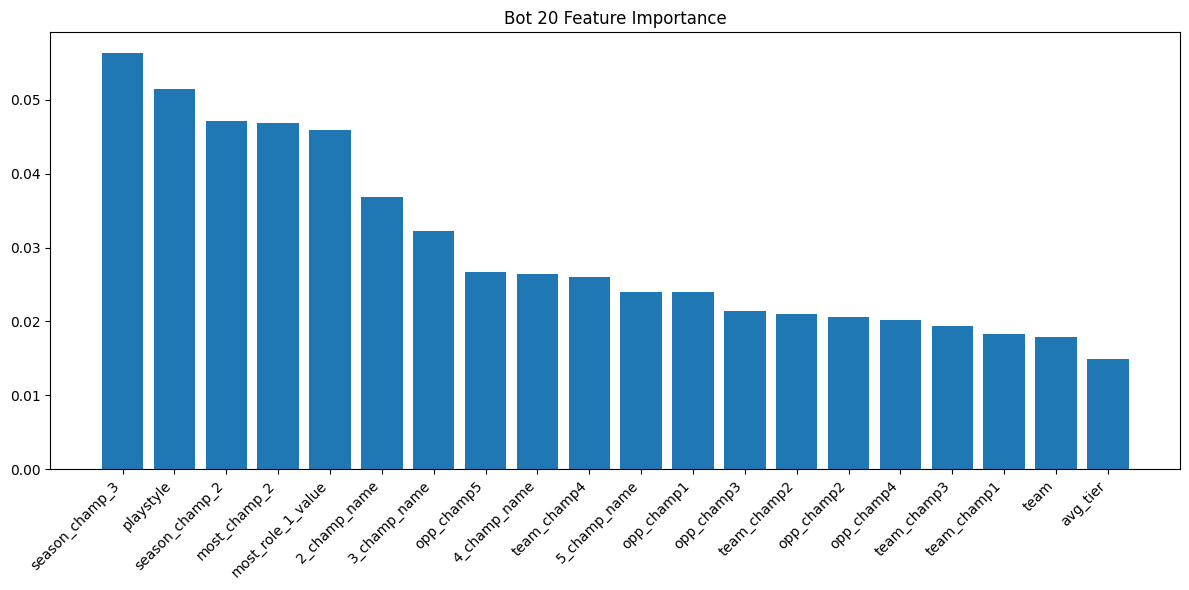

In [38]:
# Feature Importance Analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

print("\nTop 20 Least Important Features:")
print(feature_importance.tail(20))

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_importance.head(26)['feature'], feature_importance.head(26)['importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Top Feature Importance')
plt.tight_layout()
plt.show()

# # Plot feature importance
# plt.figure(figsize=(12, 6))
# plt.bar(feature_importance.tail(20)['feature'], feature_importance.tail(20)['importance'])
# plt.xticks(rotation=45, ha='right')
# plt.title('Bot 20 Feature Importance')
# plt.tight_layout()
# plt.show()

Class Distribution:
140    407
21     398
139    392
120    277
149    267
      ... 
126      4
41       3
85       3
78       2
112      2
Name: count, Length: 158, dtype: int64

Imbalance Ratio: 203.5


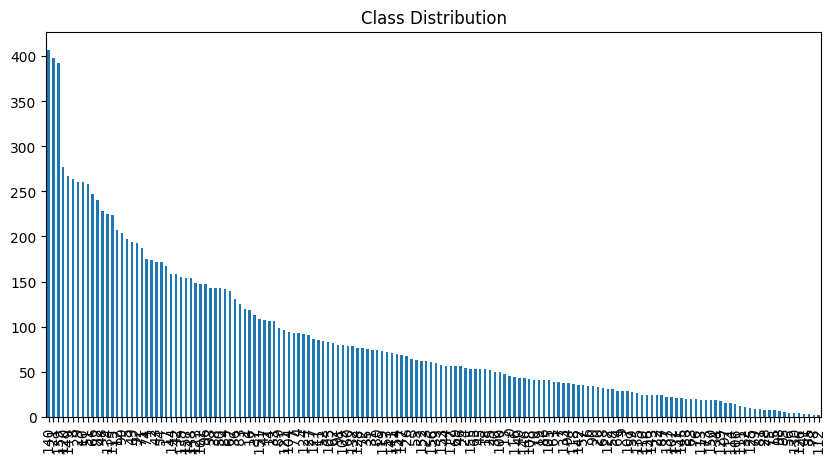

Class Distribution:
140    53
139    50
21     49
149    34
51     33
       ..
75      1
56      1
28      1
85      1
111     1
Name: count, Length: 151, dtype: int64

Imbalance Ratio: 53.0


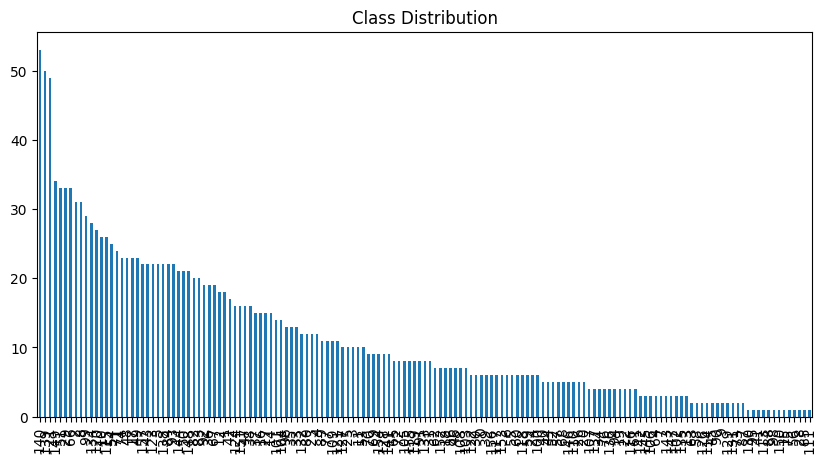

In [39]:
def analyze_class_distribution(y):
    distribution = pd.Series(y).value_counts()
    print("Class Distribution:")
    print(distribution)
    print("\nImbalance Ratio:", 
          distribution.max() / distribution.min())
    
    plt.figure(figsize=(10, 5))
    distribution.plot(kind='bar')
    plt.title('Class Distribution')
    plt.show()
    
    return distribution

# Check distribution
train_dist = analyze_class_distribution(y_train)
val_dist = analyze_class_distribution(y_val)

In [40]:
def analyze_predictability(X, y):
    # Check feature-target correlations
    correlations = []
    for col in X.columns:
        if X[col].dtype in ['int64', 'float64']:
            corr = np.corrcoef(X[col], y)[0,1]
            correlations.append((col, abs(corr)))
    
    # Sort by correlation strength
    correlations.sort(key=lambda x: x[1], reverse=True)
    
    print("Top 10 predictive features:")
    for col, corr in correlations[:10]:
        print(f"{col}: {corr:.3f}")
        
    return correlations

# Run predictability analysis
feature_predictability = analyze_predictability(X_train, y_train)

Top 10 predictive features:
most_champ_1: 0.468
team_champ2: 0.042
team_champ1: 0.037
team_champ3: 0.036
team_champ4: 0.028
most_role_2_value: 0.026
opp_champ4: 0.021
opp_champ3: 0.018
most_role_1_value: 0.016
opp_champ2: 0.010


In [41]:
# Check for missing values
def check_missing(df):
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    return pd.DataFrame({
        'Missing Count': missing,
        'Missing Percent': missing_pct
    }).sort_values('Missing Count', ascending=False)

missing_stats = check_missing(X_train)
print("Features with missing values:")
print(missing_stats[missing_stats['Missing Count'] > 0])

Features with missing values:
                Missing Count  Missing Percent
most_champ_2              404         2.942033
season_champ_3            353         2.570638
season_champ_2            195         1.420041
season_champ_1            161         1.172444


In [42]:
# Check data types
def check_datatypes(df):
    return pd.DataFrame({
        'dtype': df.dtypes,
        'unique_values': df.nunique()
    })

dtype_info = check_datatypes(X_train)
print("Feature data types:")
print(dtype_info)

Feature data types:
                       dtype  unique_values
region                  int8              4
team                    int8              2
avg_tier                int8              3
team_champ1            int64            146
team_champ2            int64            152
team_champ3            int64            142
team_champ4            int64            138
opp_champ1             int64            143
opp_champ2             int64             80
opp_champ3             int64            144
opp_champ4             int64            118
opp_champ5             int64            103
most_champ_1           int64            138
most_champ_2           Int64            134
most_role_1_value    float64             15
most_role_2_value    float64             11
season_champ_1         Int64            139
season_champ_2         Int64            129
season_champ_3         Int64            132
champ_variety_score     int8              6
playstyle               int8              6
1_champ_name

In [43]:
# Model evaluation
test_accuracy = xgb_classifier.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.3658


In [44]:
def predict_top_3_with_confidence(model, X, y_true, label_encoder):
    """
    Predict top 3 champions with confidence scores and compare with true label
    Returns a DataFrame with true champion, predicted champions and their confidence scores
    """
    # Get probabilities
    proba = model.predict_proba(X)
    
    # Get top 3 indices and probabilities
    top_3_idx = np.argsort(proba, axis=1)[:, -3:][:, ::-1]
    top_3_proba = np.take_along_axis(proba, top_3_idx, axis=1)
    
    # Initialize results DataFrame
    results = pd.DataFrame()
    
    # Add true champion
    results['True_Champion'] = label_encoder.inverse_transform(y_true)
    
    # Process each rank separately
    for i in range(3):
        # Convert indices to champion names one rank at a time
        champions = label_encoder.inverse_transform(top_3_idx[:, i])
        probabilities = top_3_proba[:, i]
        
        # Add to results
        results[f'Rank_{i+1}_Champion'] = champions
        results[f'Rank_{i+1}_Confidence'] = probabilities.round(4)
    
    # Add whether top prediction was correct
    results['Correct_Prediction'] = results['True_Champion'] == results['Rank_1_Champion']
    
    return results

In [45]:
test_predictions = predict_top_3_with_confidence(xgb_classifier, X_test.head(), y_test[:5], label_encoder)
print(test_predictions)

   True_Champion  Rank_1_Champion  Rank_1_Confidence  Rank_2_Champion  \
0             16               16             0.3204               17   
1             11              101             0.2126               98   
2             72               72             0.0566              136   
3            124               80             0.0291               24   
4             25               13             0.0486               14   

   Rank_2_Confidence  Rank_3_Champion  Rank_3_Confidence  Correct_Prediction  
0             0.0121              114             0.0121                True  
1             0.0143              139             0.0116               False  
2             0.0426               50             0.0269                True  
3             0.0220               13             0.0176               False  
4             0.0184              132             0.0183               False  


In [46]:
# Add some statistics
print("\nPrediction Statistics:")
print(f"Correct top predictions: {test_predictions['Correct_Prediction'].sum()} out of {len(test_predictions)}")
print(f"Accuracy: {test_predictions['Correct_Prediction'].mean():.2%}")

# Check if true champion appears in top 3
test_predictions['In_Top_3'] = test_predictions.apply(
    lambda row: row['True_Champion'] in [
        row['Rank_1_Champion'], 
        row['Rank_2_Champion'], 
        row['Rank_3_Champion']
    ], 
    axis=1
)

print(f"True champion in top 3: {test_predictions['In_Top_3'].sum()} out of {len(test_predictions)}")
print(f"Top 3 accuracy: {test_predictions['In_Top_3'].mean():.2%}")


Prediction Statistics:
Correct top predictions: 2 out of 5
Accuracy: 40.00%
True champion in top 3: 2 out of 5
Top 3 accuracy: 40.00%



Confidence Analysis:
Average confidence when correct: 0.1885
Average confidence when incorrect: 0.0968


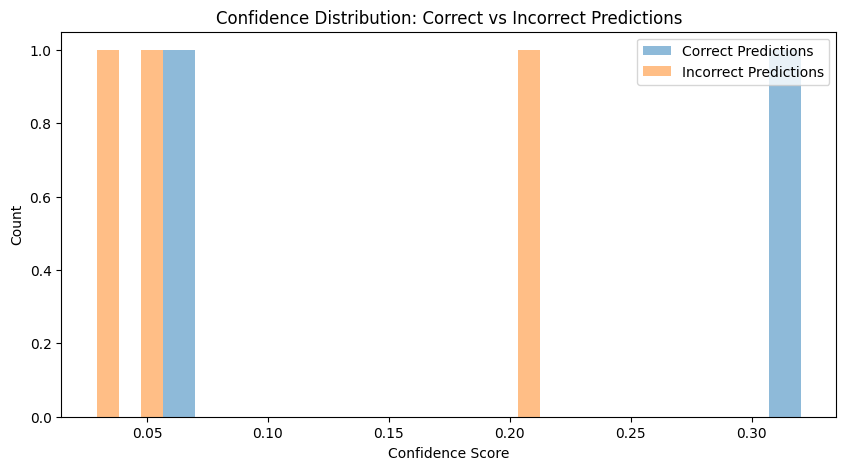

In [47]:
correct_conf = test_predictions[test_predictions['Correct_Prediction']]['Rank_1_Confidence']
incorrect_conf = test_predictions[~test_predictions['Correct_Prediction']]['Rank_1_Confidence']

if len(correct_conf) > 0 and len(incorrect_conf) > 0:
    print("\nConfidence Analysis:")
    print(f"Average confidence when correct: {correct_conf.mean():.4f}")
    print(f"Average confidence when incorrect: {incorrect_conf.mean():.4f}")

# Visualize confidence distribution for correct vs incorrect predictions
plt.figure(figsize=(10, 5))
plt.hist(correct_conf, alpha=0.5, label='Correct Predictions', bins=20)
plt.hist(incorrect_conf, alpha=0.5, label='Incorrect Predictions', bins=20)
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.title('Confidence Distribution: Correct vs Incorrect Predictions')
plt.legend()
plt.show()

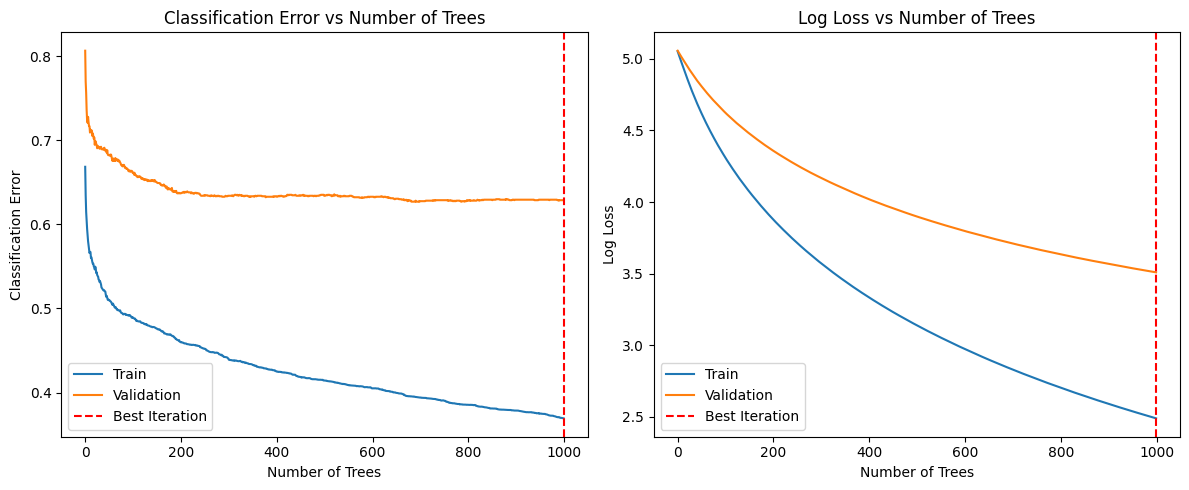

In [48]:
# Plot learning curves
results = xgb_classifier.evals_result()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results['validation_0']['merror'], label='Train')
plt.plot(results['validation_1']['merror'], label='Validation')
plt.axvline(x=best_iteration, color='r', linestyle='--', label='Best Iteration')
plt.title('Classification Error vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Classification Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['validation_0']['mlogloss'], label='Train')
plt.plot(results['validation_1']['mlogloss'], label='Validation')
plt.axvline(x=best_iteration, color='r', linestyle='--', label='Best Iteration')
plt.title('Log Loss vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Log Loss')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\marth\AppData\Local\Temp\ipykernel_3196\2025323509.py:118: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bp = plt.boxplot([group['f1_score'] for name, group in performance_df.groupby('occurrence_bin')],
C:\Users\marth\AppData\Local\Temp\ipykernel_3196\2025323509.py:118: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([group['f1_score'] for name, group in performance_df.groupby('occurrence_bin')],
C:\Users\marth\AppData\Local\Temp\ipykernel_3196\2025323509.py:128: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt 

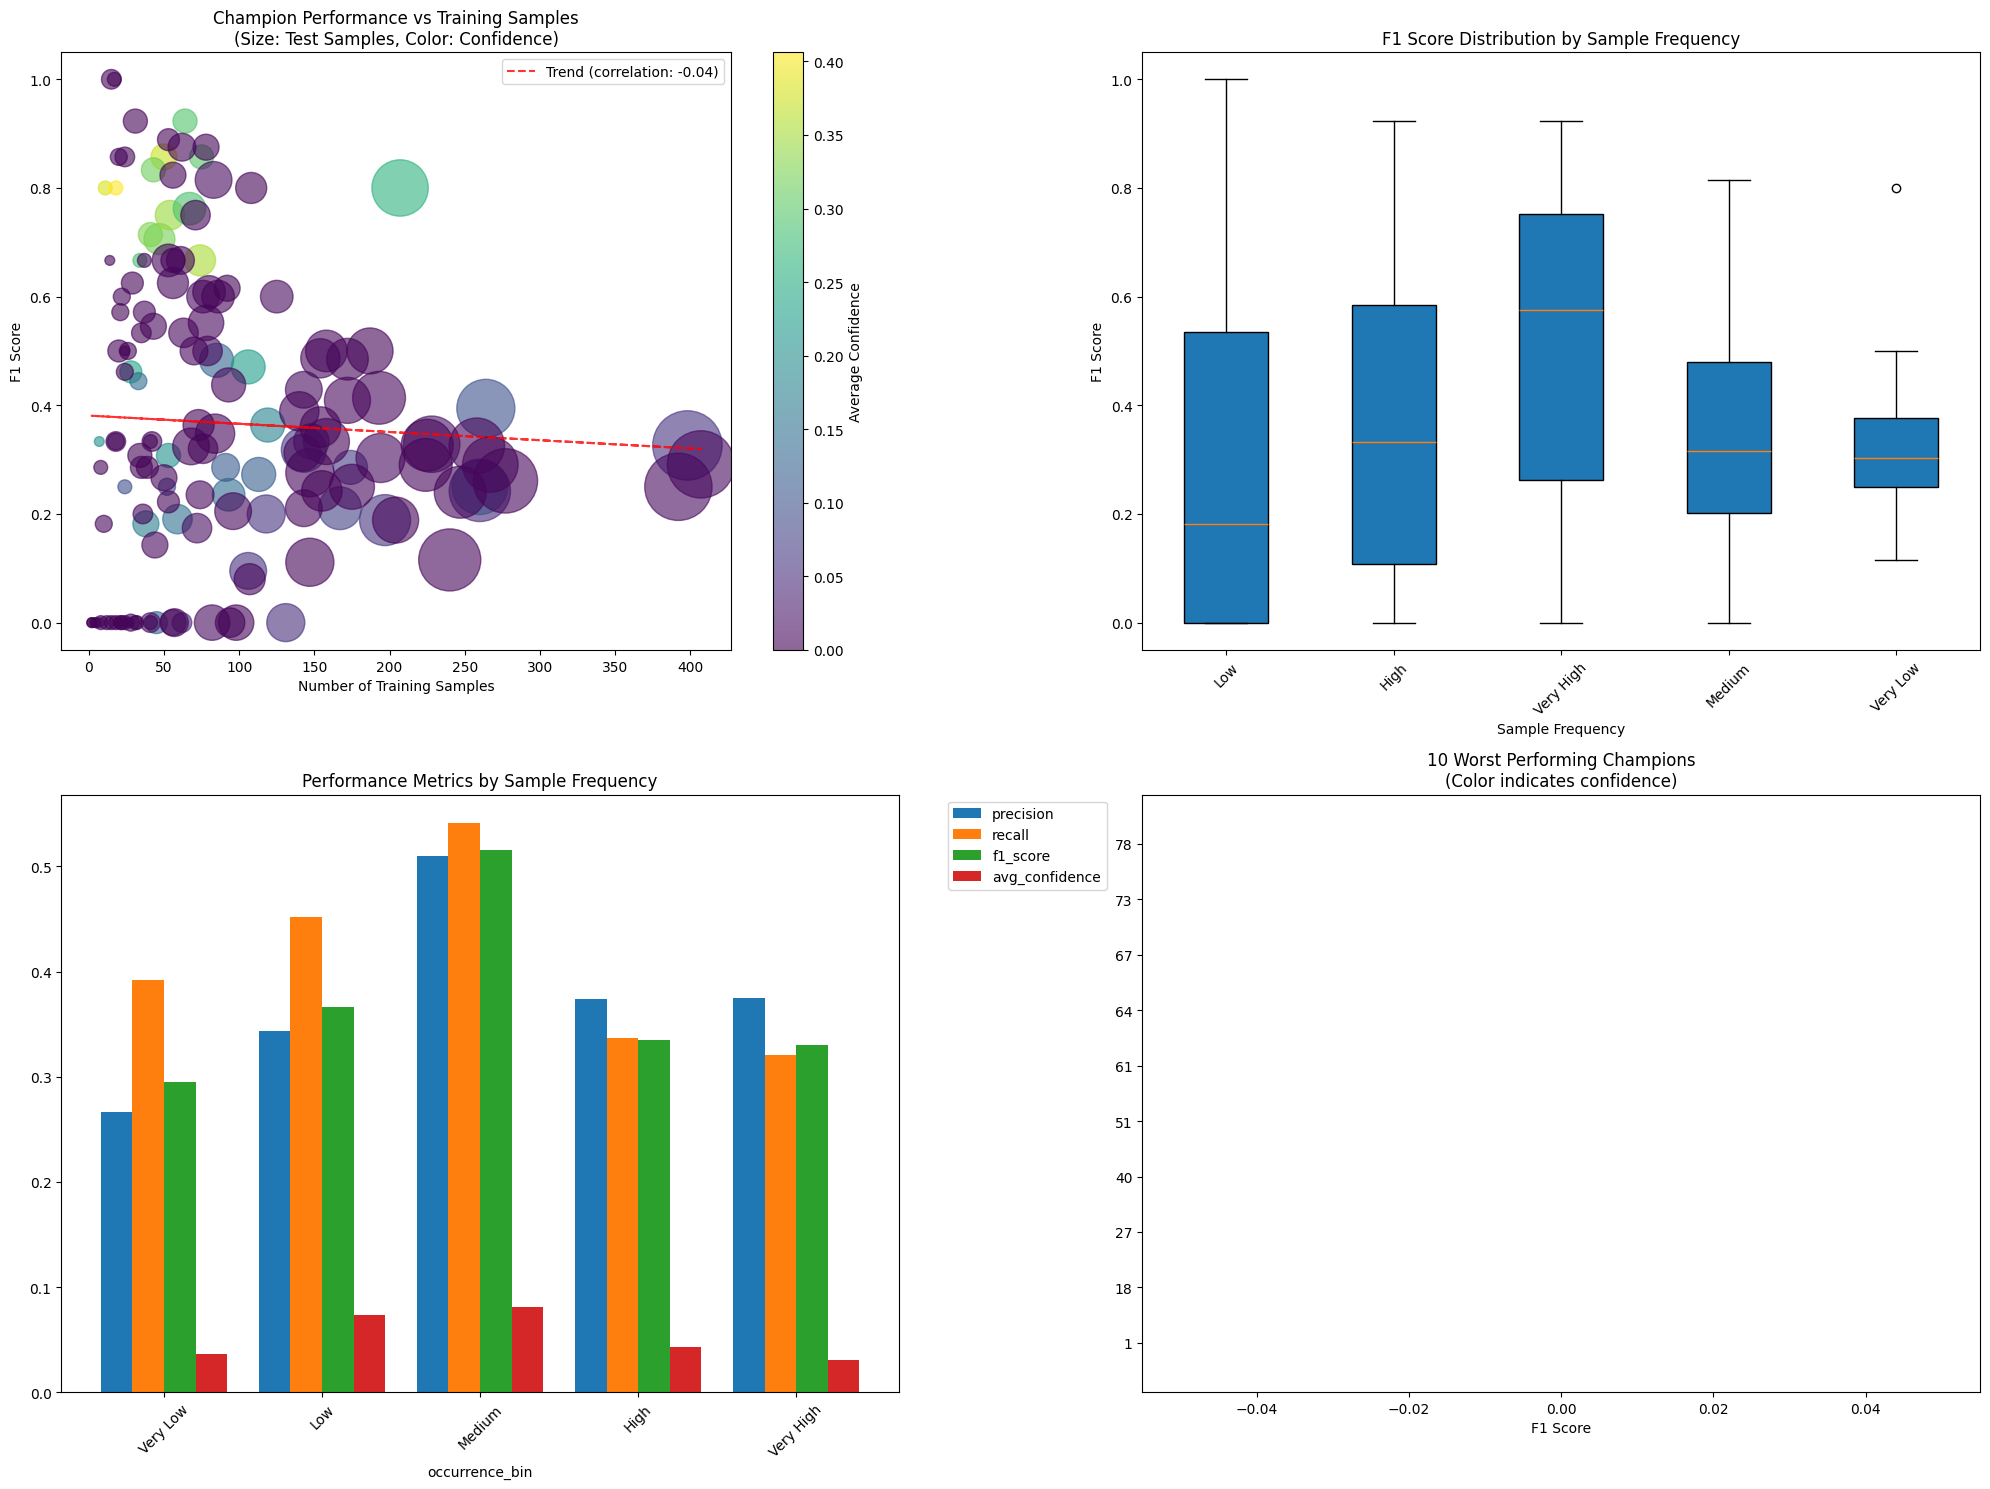


Performance Summary by Sample Frequency:
               training_samples           f1_score                       \
                           mean  min  max     mean    std    min    max   
occurrence_bin                                                            
Very Low                 14.171    2   24    0.295  0.345  0.000  1.000   
Low                      36.357   26   47    0.366  0.287  0.000  0.923   
Medium                   63.188   50   78    0.515  0.291  0.000  0.923   
High                    109.133   79  147    0.335  0.229  0.000  0.815   
Very High               223.097  148  407    0.330  0.129  0.115  0.800   

               precision recall avg_confidence  
                    mean   mean           mean  
occurrence_bin                                  
Very Low           0.267  0.392          0.036  
Low                0.343  0.452          0.073  
Medium             0.510  0.541          0.081  
High               0.374  0.336          0.043  
Very High     

C:\Users\marth\AppData\Local\Temp\ipykernel_3196\2025323509.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = performance_df.groupby('occurrence_bin').agg({
C:\Users\marth\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


In [49]:
def analyze_champion_performance(y_true, y_pred, y_prob, train_counts):
    """
    Analyze performance metrics for each champion.
    
    Parameters:
    -----------
    y_true : array-like
        True champion labels
    y_pred : array-like
        Predicted champion labels
    y_prob : array-like
        Prediction probabilities for each class
    train_counts : pd.Series
        Number of training samples for each champion
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing performance metrics for each champion
    """
    
    # Initialize results dictionary
    results = {
        'champion': [],
        'training_samples': [],
        'test_samples': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'avg_confidence': []
    }
    
    # Get unique champions
    unique_champions = np.unique(np.concatenate([y_true, y_pred]))
    
    # Calculate metrics for each champion
    for champion in unique_champions:
        # True positives and other metrics
        true_mask = (y_true == champion)
        pred_mask = (y_pred == champion)
        
        # Number of samples
        test_samples = np.sum(true_mask)
        training_samples = train_counts.get(champion, 0)
        
        # Calculate metrics
        tp = np.sum(true_mask & pred_mask)
        fp = np.sum(pred_mask) - tp
        fn = np.sum(true_mask) - tp
        
        # Precision, recall, and F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Calculate average confidence for correct predictions
        champion_idx = np.where(y_pred == champion)[0]
        avg_confidence = np.mean(y_prob[champion_idx, np.where(unique_champions == champion)[0]]) if len(champion_idx) > 0 else 0
        
        # Store results
        results['champion'].append(champion)
        results['training_samples'].append(training_samples)
        results['test_samples'].append(test_samples)
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1_score'].append(f1)
        results['avg_confidence'].append(avg_confidence)
    
    # Convert to DataFrame
    performance_df = pd.DataFrame(results)
    
    return performance_df
    
# Get counts and predictions
train_champion_counts = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
y_pred = xgb_classifier.predict(X_test)
y_prob = xgb_classifier.predict_proba(X_test)
y_test_names = label_encoder.inverse_transform(y_test)
y_pred_names = label_encoder.inverse_transform(y_pred)

# Calculate performance metrics
performance_df = analyze_champion_performance(y_test_names, y_pred_names, y_prob, train_champion_counts)

# Add occurrence bins
performance_df['occurrence_bin'] = pd.qcut(performance_df['training_samples'], 
                                         q=5, 
                                         labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Create enhanced visualizations
fig = plt.figure(figsize=(20, 15))

# 1. Scatter plot with size based on test samples
plt.subplot(2, 2, 1)
scatter = plt.scatter(performance_df['training_samples'], 
                     performance_df['f1_score'],
                     s=performance_df['test_samples']*50,
                     alpha=0.6,
                     c=performance_df['avg_confidence'],
                     cmap='viridis')
plt.colorbar(scatter, label='Average Confidence')

# Add trend line
z = np.polyfit(performance_df['training_samples'], performance_df['f1_score'], 1)
p = np.poly1d(z)
plt.plot(performance_df['training_samples'], 
         p(performance_df['training_samples']), 
         "r--", 
         alpha=0.8,
         label=f'Trend (correlation: {performance_df["training_samples"].corr(performance_df["f1_score"]):.2f})')

plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score')
plt.title('Champion Performance vs Training Samples\n(Size: Test Samples, Color: Confidence)')
plt.legend()

# 2. Box plot
plt.subplot(2, 2, 2)
bp = plt.boxplot([group['f1_score'] for name, group in performance_df.groupby('occurrence_bin')],
                 labels=performance_df['occurrence_bin'].unique(),
                 patch_artist=True)
plt.xticks(rotation=45)
plt.xlabel('Sample Frequency')
plt.ylabel('F1 Score')
plt.title('F1 Score Distribution by Sample Frequency')

# 3. Performance metrics comparison
plt.subplot(2, 2, 3)
metrics_by_bin = performance_df.groupby('occurrence_bin')[['precision', 'recall', 'f1_score', 'avg_confidence']].mean()
metrics_by_bin.plot(kind='bar', width=0.8, ax=plt.gca())
plt.title('Performance Metrics by Sample Frequency')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Top 10 worst performers with confidence
plt.subplot(2, 2, 4)
worst_performers = performance_df.nsmallest(10, 'f1_score')
bars = plt.barh(range(len(worst_performers)), 
                worst_performers['f1_score'],
                color=plt.cm.RdYlGn(worst_performers['avg_confidence']))
plt.yticks(range(len(worst_performers)), worst_performers['champion'])
plt.xlabel('F1 Score')
plt.title('10 Worst Performing Champions\n(Color indicates confidence)')

plt.tight_layout()
plt.show()

# Print analyses
print("\nPerformance Summary by Sample Frequency:")
summary = performance_df.groupby('occurrence_bin').agg({
    'training_samples': ['mean', 'min', 'max'],
    'f1_score': ['mean', 'std', 'min', 'max'],
    'precision': 'mean',
    'recall': 'mean',
    'avg_confidence': 'mean'
}).round(3)
print(summary)

print("\nDetailed Analysis of Worst Performing Champions:")
print(worst_performers[['champion', 'training_samples', 'test_samples', 
                       'precision', 'recall', 'f1_score', 'avg_confidence']].round(3))

print("\nChampions with High Confidence but Low Performance (Overconfident):")
overconfident = performance_df[
    (performance_df['avg_confidence'] > performance_df['avg_confidence'].median()) &
    (performance_df['f1_score'] < performance_df['f1_score'].median())
].sort_values('avg_confidence', ascending=False)
print(overconfident[['champion', 'training_samples', 'f1_score', 'avg_confidence']].head())

print("\nCorrelation Matrix:")
correlation_matrix = performance_df[['training_samples', 'f1_score', 'avg_confidence']].corr()
print(correlation_matrix.round(3))

# Additional Analysis: Performance vs Sample Size Ratio
performance_df['train_test_ratio'] = performance_df['training_samples'] / performance_df['test_samples']
print("\nPerformance vs Train/Test Ratio Correlation:", 
      performance_df['train_test_ratio'].corr(performance_df['f1_score']).round(3))

# Identify champions needing attention
threshold_samples = performance_df['training_samples'].median()
threshold_f1 = performance_df['f1_score'].median()

needs_attention = performance_df[
    (performance_df['training_samples'] < threshold_samples) &
    (performance_df['f1_score'] < threshold_f1)
].sort_values('f1_score')

print("\nRecommendations for Improvement:")
print(f"Number of champions needing attention: {len(needs_attention)}")
print("\nPriority Champions for Data Collection:")
print(needs_attention[['champion', 'training_samples', 'f1_score', 'avg_confidence']].head())

# Save analysis results
analysis_results = {
    'worst_performers': worst_performers['champion'].tolist(),
    'overconfident_champions': overconfident['champion'].tolist(),
    'needs_attention': needs_attention['champion'].tolist(),
    'correlation_stats': correlation_matrix.to_dict()
}

print("\nSummary Statistics:")
print(f"Average F1 Score: {performance_df['f1_score'].mean():.3f}")
print(f"Median F1 Score: {performance_df['f1_score'].median():.3f}")
print(f"F1 Score Standard Deviation: {performance_df['f1_score'].std():.3f}")

## <span style='color:#ff5f27'>🗄 Save Model</span>

### <span style="color:#ff5f27;">⚙️ Model Schema</span>

In [50]:
import joblib
# Save the model and label encoder
save_dir = os.path.join(current_dir, 'model')
filepath = os.path.join(save_dir, 'champion_predictor.json')
filepath2 = os.path.join(save_dir, 'label_encoder.joblib')
        
xgb_classifier.save_model(filepath)
joblib.dump(label_encoder, filepath2)

['C:\\Users\\marth\\OneDrive - KTH\\[Y1] Period 2\\ID2223 Scalable Machine Learning and Deep Learning\\Projects\\Final Pj\\ID2223-Final-Project\\model\\label_encoder.joblib']